# Analyze Simple Basel M1 fit

In [1]:
import torch as torch
from torch.utils.data import *
import numpy as np
from os import path
from baselM1model import *
import tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from fnmdataset import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TEST_PATH = '/home/user/notebooks/data/test'
MODEL_PATH = '/home/user/notebooks/data/model/baselm1'
MODEL_SAVED = MODEL_PATH + '/baselm1.pth'

## Plot losses

In [3]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
checkpoint = torch.load(MODEL_SAVED)

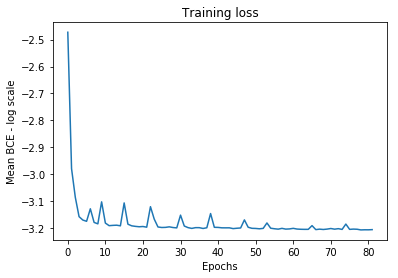

In [5]:
plt.plot(np.log(checkpoint['train_losses']))
plt.xlabel("Epochs")
plt.ylabel('Mean BCE - log scale')
plt.title('Training loss')
plt.savefig(MODEL_PATH+'/training_loss.png', dpi=200)

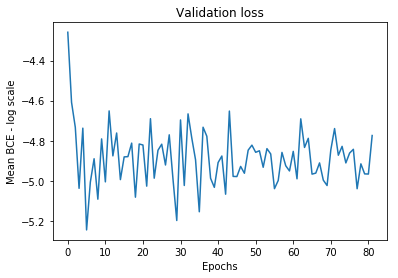

In [6]:
plt.plot(np.log(checkpoint['valid_losses']))
plt.xlabel("Epochs")
plt.ylabel('Mean BCE - log scale')
plt.title('Validation loss')
plt.savefig(MODEL_PATH+'/valid_loss.png', dpi=200)

## Model Performance on Testing Dataset

In [7]:
test_acq_numpy, test_idx_to_seq, test_seq_numpy = load_data(TEST_PATH)

Acquisition numpy: /home/user/notebooks/data/test/fnm_input_acq.npy
Sequence numpy: /home/user/notebooks/data/test/fnm_input_seq_*.npy
Index to Sequence Index numpy: /home/user/notebooks/data/test/fnm_input_idx_to_seq.npy
loading file: /home/user/notebooks/data/test/fnm_input_seq_0.npy


In [8]:
test_ds = FNMDataset(test_acq_numpy, test_idx_to_seq, test_seq_numpy)

In [9]:
BATCH_SIZE = 8000
NUM_WORKERS = 5
BATCH_SHOUT = 51

In [10]:
testDL = DataLoader(test_ds, batch_size=BATCH_SIZE, \
    collate_fn=paddingCollator, num_workers=NUM_WORKERS)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BaselM1Model(11, 50, 5).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

if torch.cuda.device_count() > 1:
    print("Training on", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

Training on 2 GPUs


In [12]:
target_1y = []
predic_1y = []
dlq_source = []

In [13]:
model.eval()
tqdm_inner = tqdm.tqdm(testDL)
current_pred_idx = 0
for bidx, (seq, seq_len, acq, def1y) in enumerate(tqdm_inner):
    seq = seq.to(device)
    acq = acq.to(device)
    seq_len = seq_len.to(device)
    def1y = def1y.to(device)

    def1y_hat = model(seq, acq, seq_len, def1y)
    for s in range(def1y.shape[0]):
        target_1y.append(def1y[s, 0:seq_len[s]].cpu().detach().numpy().tolist())
        predic_1y.append(def1y_hat[s, 0:seq_len[s]].cpu().detach().numpy().tolist())
        dlq_one_hot = seq[s, 0:seq_len[s], 0:8].cpu().detach().numpy()
        dlq = np.argmax(dlq_one_hot, axis=1)
        dlq_source.append(dlq.tolist())    

  0%|          | 0/318 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/torch/nn/modules/rnn.py:525: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.num_layers, self.dropout, self.training, self.bidirectional)
100%|██████████| 318/318 [16:49<00:00,  2.78s/it]


In [19]:
print('len(target_1y)={:,}, len(predic_1y)={:,}, len(dlq)={:,}'.format(len(target_1y), len(predic_1y), len(dlq_source)))

len(target_1y)=2,541,990, len(predic_1y)=2,541,990, len(dlq)=2,541,990


In [20]:
target_1y_np = np.hstack(target_1y)
predic_1y_np = np.hstack(predic_1y)
dlq_source_np = np.hstack(dlq_source)

In [21]:
np.save(MODEL_PATH + '/target_1y.npy', target_1y_np)
np.save(MODEL_PATH + '/predic_1y.npy', predic_1y_np)
np.save(MODEL_PATH + '/dlq_source_np.npy', dlq_source_np)

In [22]:
print('predic_1y_np:{:,}  target_1y_np:{:,}, dlq_source_np:{:,}'.format(predic_1y_np.shape[0], target_1y_np.shape[0], dlq_source_np.shape[0]))

predic_1y_np:169,288,303  target_1y_np:169,288,303, dlq_source_np:169,288,303


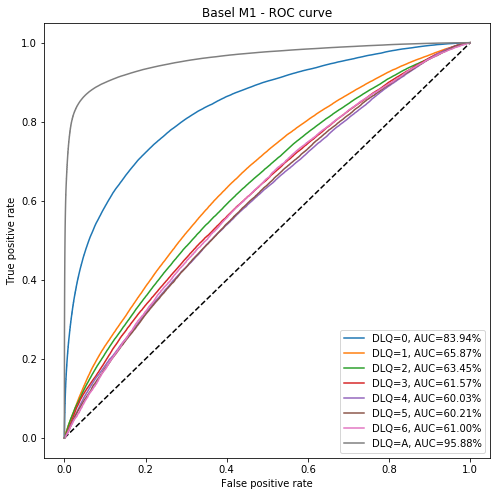

In [23]:
plt.figure(1, figsize=[8, 8])
plt.plot([0, 1], [0, 1], 'k--')
for dlq in range(7):
    idx = np.where(dlq_source_np==dlq)
    fpr, tpr, thresholds = roc_curve(target_1y_np[idx], predic_1y_np[idx])
    auc = roc_auc_score(target_1y_np[idx], predic_1y_np[idx])
    plt.plot(fpr, tpr, label='DLQ={}, AUC={:.2f}%'.format(dlq, auc*100))
fpr, tpr, thresholds = roc_curve(target_1y_np, predic_1y_np)
auc = roc_auc_score(target_1y_np, predic_1y_np)
plt.plot(fpr, tpr, label='DLQ=A, AUC={:.2f}%'.format(auc*100))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Basel M1 - ROC curve')
plt.legend(loc='best')
plt.savefig(MODEL_PATH+'/roc_curves.png', dpi=200)

In [25]:
from sklearn import metrics
import pandas as pd

In [40]:
p = metrics.precision_score(target_1y_np, 1*(predic_1y_np > 0.5))
r = metrics.recall_score(target_1y_np, 1*(predic_1y_np > 0.5))
f1 = metrics.f1_score(target_1y_np, 1*(predic_1y_np > 0.5))

In [41]:
scores = pd.DataFrame({'D': 'A', 'Precision': [p], 'Recall': [r], 'F1': [f1]})

In [51]:
p = metrics.precision_score(target_1y_np, 1*(predic_1y_np > 0.5))
r = metrics.recall_score(target_1y_np, 1*(predic_1y_np > 0.5))
f1 = metrics.f1_score(target_1y_np, 1*(predic_1y_np > 0.5))
scores = pd.DataFrame({'D': 'A', 'Precision': [p], 'Recall': [r], 'F1': [f1]})
for dlq in range(7):
    idx = np.where(dlq_source_np==dlq)
    p = metrics.precision_score(target_1y_np[idx], 1*(predic_1y_np[idx] > 0.5))
    r = metrics.recall_score(target_1y_np[idx], 1*(predic_1y_np[idx] > 0.5))
    f1 = metrics.f1_score(target_1y_np[idx], 1*(predic_1y_np[idx] > 0.5))
    scores = scores.append(pd.DataFrame({'D': dlq, 'Precision': [p], 'Recall': [r], 'F1': [f1]}))
    

In [53]:
scores.set_index('D')

,F1,Precision,Recall
D,,,
A,0.481551,0.428043,0.550350
0,0.000620,0.074534,0.000311
1,0.042165,0.118030,0.025667
2,0.313571,0.219629,0.547944
3,0.485179,0.325166,0.955258
4,0.618954,0.450035,0.990874
5,0.739535,0.587163,0.998702
6,0.873578,0.775533,1.000000
